In [1]:
import torch
import os
from model_lorentz import GPTConfig, GPT

root_dir = "/raid/out-tinystories"  # Adjust this path if necessary

# Get a list of all experiment folders
ckpt_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)]

ckpt_dirs

['/raid/out-tinystories/ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.10.pt',
 '/raid/out-tinystories/ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_20_n_embd_40_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_1_19.23.pt',
 '/raid/out-tinystories/ckpt_mode_original_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.15.pt',
 '/raid/out-tinystories/ckpt_cmode_fixed_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.13.pt',
 '/raid/out-tinystories/ckpt_mode_original_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_14.29.pt',
 '/raid/out-tinystories/ckpt

In [50]:
checkpoint_path = ckpt_dirs[-3]
print(checkpoint_path)
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load the model arguments from the checkpoint
model_args = checkpoint['model_args']

# Initialize the model with the loaded config
gpt_config = GPTConfig(**model_args)
model = GPT(gpt_config)

# Load the model state dictionary
state_dict = checkpoint['model']

# Remove unwanted prefix if present
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

# Load state dict into the model
model.load_state_dict(state_dict)

/raid/out-tinystories/ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_1_19.14.pt
number of parameters: 40.56M


<All keys matched successfully>

In [51]:
# Iterate through the layers and print the value of the 'c' parameter in hyperbolic mode
cs = []
for i, block in enumerate(model.transformer.h):
    # if isinstance(block.attn, CausalSelfAttention) and block.attn.mode == 'hyperbolic':
    print(f"Layer {i} c:", end=' ')
    l = []
    for w in block.attn.c.flatten():
        print(f"{w.item():.3f}", end=' ') 
        l.append(w.item())
    cs.append(l)
    print('\n')
cs = np.array(cs)

Layer 0 c: 0.339 0.398 0.410 0.647 0.620 0.621 0.613 0.692 0.497 0.664 0.633 0.609 

Layer 1 c: 0.607 0.478 0.688 1.087 0.820 0.858 0.749 1.313 1.131 0.936 1.170 0.860 

Layer 2 c: 2.053 2.099 1.341 1.343 1.643 1.172 0.861 2.001 1.512 1.898 1.927 1.866 

Layer 3 c: 2.300 1.967 1.717 2.102 2.714 2.416 2.538 1.808 1.500 2.141 1.813 2.582 

Layer 4 c: 2.266 2.668 2.787 1.898 2.382 2.328 2.506 2.019 2.994 2.281 2.450 2.539 

Layer 5 c: 2.975 3.047 3.157 2.477 3.137 1.795 2.803 2.106 3.113 2.326 1.320 2.531 

Layer 6 c: 1.489 2.753 3.451 2.534 3.571 2.364 2.137 1.845 3.284 3.456 3.160 3.170 

Layer 7 c: 1.757 3.330 1.446 0.990 3.989 3.967 2.439 3.672 3.819 3.970 2.985 3.011 

Layer 8 c: 3.768 2.305 4.257 1.776 3.194 4.275 4.265 3.457 2.842 4.094 1.210 1.686 

Layer 9 c: 3.906 3.972 2.108 3.432 4.121 1.474 3.491 3.078 4.159 1.609 3.705 3.395 

Layer 10 c: 2.762 2.794 2.308 2.762 3.182 2.696 1.302 1.211 2.048 2.418 2.640 2.329 

Layer 11 c: 0.780 1.935 1.923 2.767 0.754 2.048 2.201 0.749 1.30

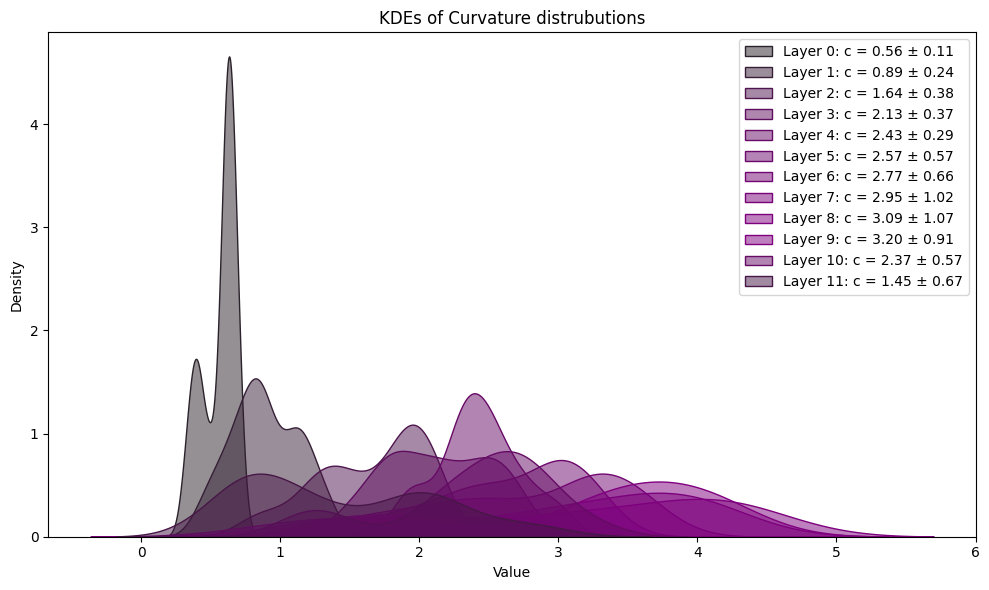

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the means of each row in cs
means = np.array([c.mean() for c in cs])

# Normalize the means to get values between 0 and 1 (for color mapping)
normalized_means = (means - means.min()) / (means.max() - means.min())

# Generate a dark palette, and assign colors based on the normalized means
palette = sns.dark_palette("purple", as_cmap=True)  # Using 'purple' as a base color

# Create the plot
plt.figure(figsize=(10, 6))

# Loop over each row in cs and plot its histogram
for i, (c, norm_mean) in enumerate(zip(cs, normalized_means)):
    mean = c.mean()
    std = c.std()
    
    # Convert the normalized mean to an actual color from the palette
    color = palette(norm_mean)
    
    # Plot the histogram with transparency alpha=0.5 and color depending on the mean
    # plt.hist(c, bins=10, alpha=0.5, label=f"Layer {i}: c = {mean:.2f} ± {std:.2f}", color=color)
    sns.kdeplot(c, fill=True, color=color, alpha=0.5, label=f"Layer {i}: c = {mean:.2f} ± {std:.2f}", common_norm=False, bw_adjust=0.7)


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDEs of Curvature distrubutions')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
for i, block in enumerate(model.transformer.h):
    for name, param in block.named_parameters():
        print(f"Name: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")
    break

Name: ln_1.weight | Shape: torch.Size([384]) | Requires Grad: True
Name: attn.c | Shape: torch.Size([1, 12, 1, 1]) | Requires Grad: True
Name: attn.c_attn.weight | Shape: torch.Size([1152, 384]) | Requires Grad: True
Name: attn.c_proj.weight | Shape: torch.Size([384, 384]) | Requires Grad: True
Name: ln_2.weight | Shape: torch.Size([384]) | Requires Grad: True
Name: mlp.c_fc.weight | Shape: torch.Size([1536, 384]) | Requires Grad: True
Name: mlp.c_proj.weight | Shape: torch.Size([384, 1536]) | Requires Grad: True


In [58]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Define the path to your root logs directory
root_log_dir = "/raid/runs_train/10.04"  # Adjust this path if necessary

# Get a list of all experiment folders
log_dirs = [os.path.join(root_log_dir, d) for d in os.listdir(root_log_dir)]

log_dirs

['/raid/runs_train/10.04/mode_original_n_layer_12_n_head_12_n_embd_384_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_1_19.15',
 '/raid/runs_train/10.04/cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_384_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_1_19.14',
 '/raid/runs_train/10.04/cmode_learned_init_curvature_1.0_n_layer_12_n_head_20_n_embd_40_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_100000_batch_size_1_gradient_accumulation_steps_1_19.23']

In [30]:
log_dirs_bs1 = [log_dirs[0], log_dirs[2]]
log_dirs_bs2 = [log_dirs[1], log_dirs[2]]
log_dirs_o = log_dirs[:4]
log_dirs_l = log_dirs[4:]

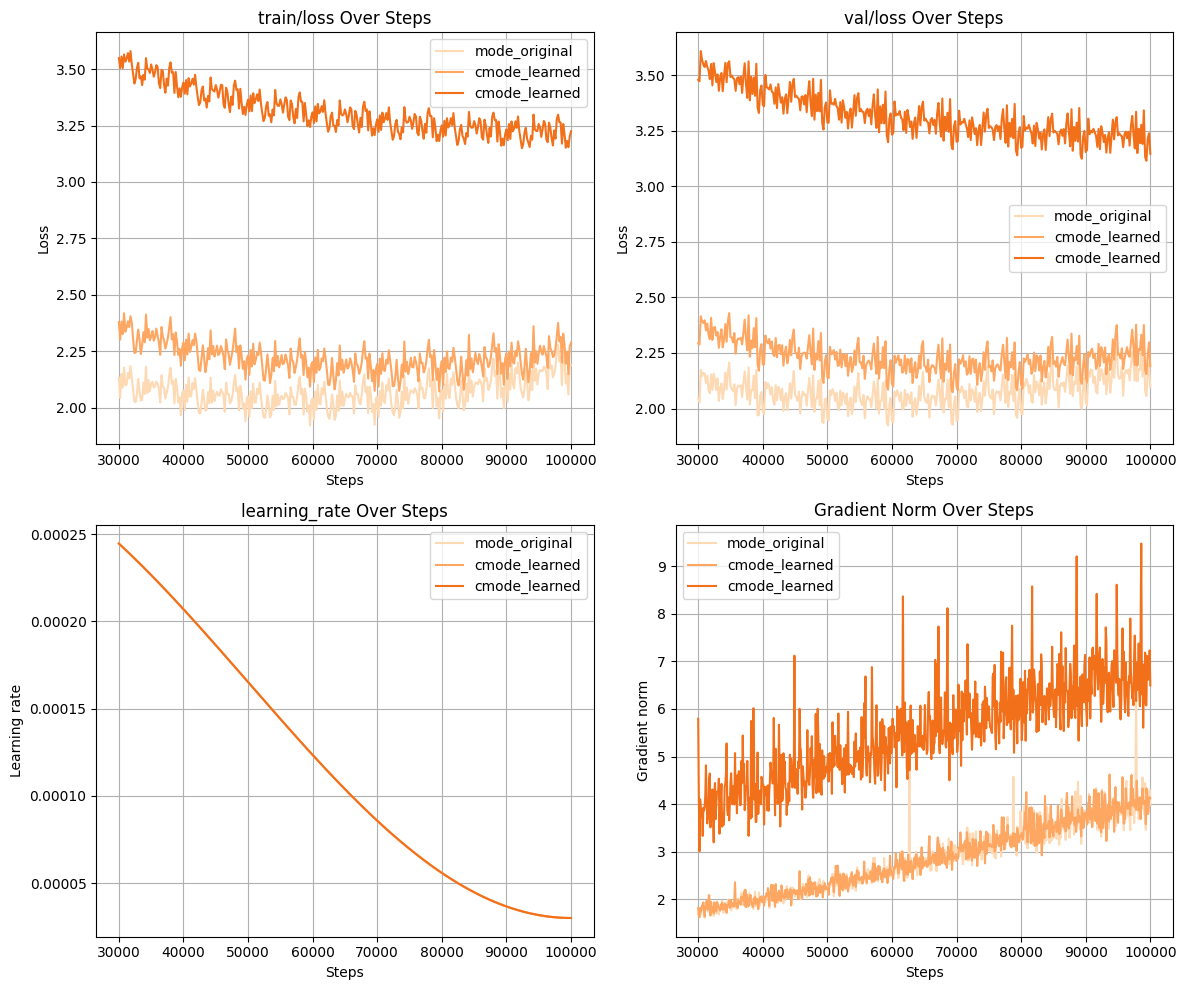

In [60]:
logs_to_show=log_dirs
exp_names = [n[23:36] for n in logs_to_show]
# exp_names = ['c learned from 0.01', 'c learned from 1', 'orig', 'c learned from 1', 'c fixed 0.01']

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags (train/loss, val/loss, learning_rate, Gradient Norm)
    tags = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']
    
    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}
    
    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data


metrics = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']

# exp_names = ['hyperbolic c=1e-5', 'original']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            length = len(data[metric]['steps'])
            from_, to_ = int(0.3*length), int(1*length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e)
    
    # if not 'loss' in metric:
    # ax.set_yscale('log')  
    ax.set_xlabel('Steps')
    # ax.set_xlim([0, 1.1*max(steps)])
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
# plt.savefig('runs_head.jpg')
plt.show()

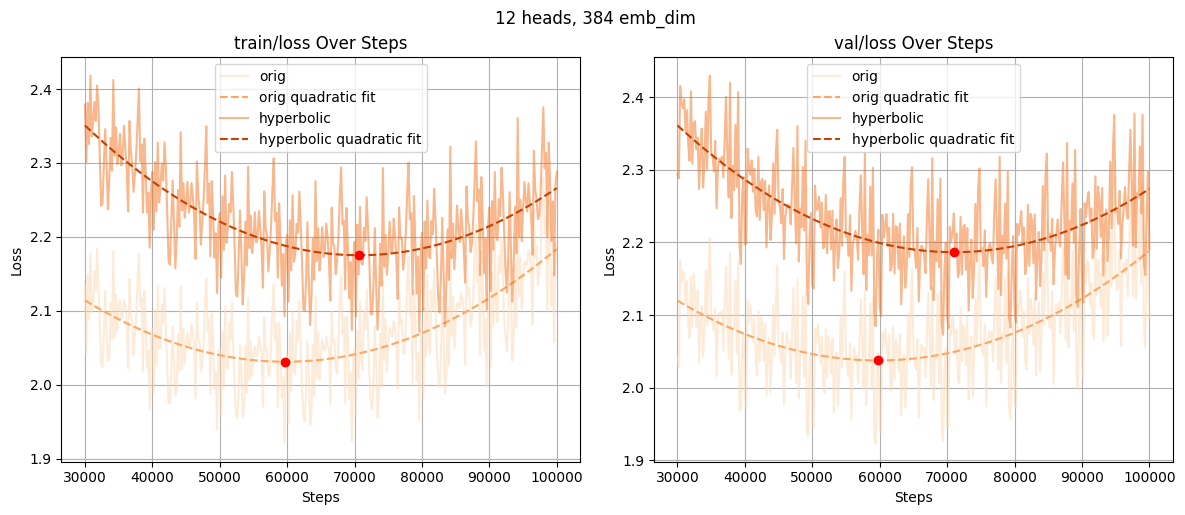

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import seaborn as sns

# Set the Seaborn color palette
palette = sns.color_palette("Oranges", n_colors=4)  # husl, deep, bright, etc.
plt.rc('axes', prop_cycle=plt.cycler('color', palette))

# Function to fit a parabola and plot
def fit_and_plot_parabola(ax, steps, values, label):
    # Fit a quadratic function (parabola)
    coefs = np.polyfit(steps, values, 2)  # 2 for quadratic fit
    poly = np.poly1d(coefs)
    
    # Generate points for plotting the parabola
    fitted_values = poly(steps)
    
    # Plot the fitted parabola
    ax.plot(steps, fitted_values, linestyle='--', label=f'{label} quadratic fit')
    
    # Find the minimum of the parabola
    min_step = -coefs[1] / (2 * coefs[0])
    min_value = poly(min_step)
    
    # Highlight the minimum point
    ax.scatter(min_step, min_value, color='red', zorder=5)
    
    return min_step, min_value

# Filter logs to only show train/loss and val/loss
logs_to_show = log_dirs[:-1]
# exp_names = [n[23:36] for n in logs_to_show]
exp_names = ['hyperbolic', 'orig'][::-1]

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    # Get available scalar tags (train/loss, val/loss)
    tags = ['train/loss', 'val/loss']

    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}

    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data

metrics = ['train/loss', 'val/loss']  # Only include loss metrics

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            length = len(data[metric]['steps'])
            from_, to_ = int(0.3*length), int(length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e, alpha=0.5)
            
            # Fit the loss with a parabola and highlight the minimum point
            fit_and_plot_parabola(ax, steps, values, e)
    
    ax.set_xlabel('Steps')
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
plt.suptitle('12 heads, 384 emb_dim', y=1.02)
plt.show()